In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import f1_score, confusion_matrix
import math

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 한글 폰트 설정
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fontprop = font_manager.FontProperties(fname=font_path)
rc('font', family=fontprop.get_name())

# 1. 데이터 로드
train = pd.read_csv('/apps/study_promptengineerings/dacon/real_estate_fraud/train.csv')
test = pd.read_csv('/apps/study_promptengineerings/dacon/real_estate_fraud/test.csv')

# ID 매핑 저장 및 컬럼 제거
id_mapping = pd.Series(test['ID'].values, index=test.index)
train = train.drop('ID', axis=1)
test = test.drop('ID', axis=1)

# 결측치 확인
print("Train set missing values:")
print(train.isnull().sum())
print("\nTest set missing values:")
print(test.isnull().sum())


Train set missing values:
매물확인방식      0
보증금         0
월세          0
전용면적      787
해당층       229
총층         16
방향          0
방수         16
욕실수        18
주차가능여부      0
총주차대수     696
관리비         0
중개사무소       0
제공플랫폼       0
게재일         0
허위매물여부      0
dtype: int64

Test set missing values:
매물확인방식      0
보증금         0
월세          0
전용면적      184
해당층        50
총층          2
방향          0
방수          2
욕실수         2
주차가능여부      0
총주차대수     175
관리비         0
중개사무소       0
제공플랫폼       0
게재일         0
dtype: int64


In [3]:

# 2. 결측치 처리
# 2.1 총층 처리
train['총층'] = train['총층'].fillna(train['총층'].median())
test['총층'] = test['총층'].fillna(test['총층'].median())

# 2.2 욕실수 처리
train['욕실수'] = train['욕실수'].fillna(train.groupby('방수')['욕실수'].transform('median'))
test['욕실수'] = test['욕실수'].fillna(test.groupby('방수')['욕실수'].transform('median'))
train['욕실수'] = train['욕실수'].fillna(train['욕실수'].median())
test['욕실수'] = test['욕실수'].fillna(test['욕실수'].median())

# 2.3 해당층 처리
train['해당층'] = train['해당층'].fillna(train['해당층'].median())
test['해당층'] = test['해당층'].fillna(test['해당층'].median())

# 2.4 전용면적 처리
train['전용면적'] = train['전용면적'].fillna(train.groupby(['방수', '욕실수'])['전용면적'].transform('median'))
test['전용면적'] = test['전용면적'].fillna(test.groupby(['방수', '욕실수'])['전용면적'].transform('median'))
train['전용면적'] = train['전용면적'].fillna(train['전용면적'].median())
test['전용면적'] = test['전용면적'].fillna(test['전용면적'].median())

# 2.5 총주차대수 처리
train.loc[train['주차가능여부'] == '불가능', '총주차대수'] = train.loc[train['주차가능여부'] == '불가능', '총주차대수'].fillna(0)
test.loc[test['주차가능여부'] == '불가능', '총주차대수'] = test.loc[test['주차가능여부'] == '불가능', '총주차대수'].fillna(0)

train.loc[train['주차가능여부'] == '가능', '총주차대수'] = train.loc[train['주차가능여부'] == '가능', '총주차대수'].fillna(
    train.loc[train['주차가능여부'] == '가능', '총주차대수'].median())
test.loc[test['주차가능여부'] == '가능', '총주차대수'] = test.loc[test['주차가능여부'] == '가능', '총주차대수'].fillna(
    test.loc[test['주차가능여부'] == '가능', '총주차대수'].median())

# 2.6 방수 처리
# 중개사무소별 평균값으로 방수 결측치 대체
train['방수'] = train['방수'].fillna(train.groupby('중개사무소')['방수'].transform('mean'))
test['방수'] = test['방수'].fillna(test.groupby('중개사무소')['방수'].transform('mean'))

# 남아있는 결측치는 전체 평균값으로 대체
train['방수'] = train['방수'].fillna(train['방수'].mean())
test['방수'] = test['방수'].fillna(test['방수'].mean())


# 결측치 확인
print("Train set missing values:")
print(train.isnull().sum())
print("\nTest set missing values:")
print(test.isnull().sum())


Train set missing values:
매물확인방식    0
보증금       0
월세        0
전용면적      0
해당층       0
총층        0
방향        0
방수        0
욕실수       0
주차가능여부    0
총주차대수     0
관리비       0
중개사무소     0
제공플랫폼     0
게재일       0
허위매물여부    0
dtype: int64

Test set missing values:
매물확인방식    0
보증금       0
월세        0
전용면적      0
해당층       0
총층        0
방향        0
방수        0
욕실수       0
주차가능여부    0
총주차대수     0
관리비       0
중개사무소     0
제공플랫폼     0
게재일       0
dtype: int64


In [4]:
import pandas as pd

# 1️⃣ 게재일을 날짜 형식으로 변환 (NaT 발생 시 자동 처리)
train["게재일"] = pd.to_datetime(train["게재일"], errors="coerce")
test["게재일"] = pd.to_datetime(test["게재일"], errors="coerce")
# 2️⃣ 기준 날짜 설정 (최소 날짜)
min_date_train = train["게재일"].min()
min_date_test = train["게재일"].min()
# 3️⃣ 최소 날짜 기준으로 주차 계산 (음수 방지)
train["게재일_변환"] = ((train["게재일"] - min_date_train).dt.days // 7).clip(lower=0)
test["게재일_변환"] = ((test["게재일"] - min_date_test).dt.days // 7).clip(lower=0)


# 4️⃣ 게재일을 변환된 값으로 대체하고, 게재일_변환 열 삭제
train["게재일"] = train["게재일_변환"]  # 기존 게재일을 변환된 값으로 대체
train.drop(columns=["게재일_변환"], inplace=True)  # 게재일_변환 열 삭제
test["게재일"] = test["게재일_변환"]  # 기존 게재일을 변환된 값으로 대체
test.drop(columns=["게재일_변환"], inplace=True)  # 게재일_변환 열 삭제

# 결과 확인
print(train)




     매물확인방식          보증금      월세   전용면적  해당층    총층   방향   방수  욕실수 주차가능여부  \
0      현장확인  402500000.0  470000  23.14  4.0  15.0   서향  1.0  1.0     가능   
1      현장확인  170500000.0  200000  29.98  3.0   4.0  남동향  2.0  1.0    불가능   
2      전화확인  114000000.0  380000  23.14  2.0   3.0   동향  1.0  1.0    불가능   
3      현장확인  163500000.0   30000  36.30  3.0   9.0  남동향  2.0  1.0     가능   
4      현장확인  346000000.0  530000  29.98  3.0   3.0   동향  2.0  1.0    불가능   
...     ...          ...     ...    ...  ...   ...  ...  ...  ...    ...   
2447   서류확인  159000000.0  550000  48.95  3.0   3.0   남향  2.0  1.0    불가능   
2448   서류확인  158500000.0  750000  23.14  2.0   4.0   남향  1.0  1.0    불가능   
2449   전화확인  329000000.0  610000  17.50  8.0  20.0  남서향  1.0  1.0     가능   
2450   현장확인   31000000.0  400000  22.87  8.0   9.0  남동향  2.0  1.0     가능   
2451   전화확인  126000000.0  340000  29.89  4.0   6.0   북향  2.0  1.0    불가능   

      총주차대수  관리비       중개사무소 제공플랫폼  게재일  허위매물여부  
0      40.0   96  t93Nt6I2I0  B플랫폼   

In [5]:
# 3. 피처 인코딩
# 3.1 레이블 인코딩, 순서나 크기
label_cols = ['방수', '방향', '욕실수']
for col in label_cols:
    le = LabelEncoder()
    combined_data = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(combined_data)
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))
    
# 3.2 원-핫 인코딩
onehot_cols = ['매물확인방식', '중개사무소', '제공플랫폼', '게재일', '주차가능여부', '해당층', '총층', '총주차대수']
onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')

# 모든 값을 문자열로 변환
train[onehot_cols] = train[onehot_cols].astype(str)
test[onehot_cols] = test[onehot_cols].astype(str)

# 원-핫 인코딩 학습 및 변환
onehot.fit(pd.concat([train[onehot_cols], test[onehot_cols]]))

# 피처 이름 생성
feature_names = onehot.get_feature_names_out(onehot_cols)

# 인코딩 적용
train_encoded = onehot.transform(train[onehot_cols])
test_encoded = onehot.transform(test[onehot_cols])

# 데이터프레임 결합
train = pd.concat([
    train.drop(columns=onehot_cols),
    pd.DataFrame(train_encoded, index=train.index, columns=feature_names)
], axis=1)

test = pd.concat([
    test.drop(columns=onehot_cols),
    pd.DataFrame(test_encoded, index=test.index, columns=feature_names)
], axis=1)

# 4. 데이터 준비
X = train.drop('허위매물여부', axis=1)
y = train['허위매물여부']

# # 클래스 가중치 계산
# class_weights = dict(zip(
#     np.unique(y),
#     1 / np.bincount(y) * len(y) / 2
# ))



In [6]:

# 5. 모델 학습 및 예측
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'num_leaves': 25,
    'learning_rate': 0.05,
    'seed': 42,
    'metric': 'binary_logloss',
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'min_child_samples': 5,
    'scale_pos_weight': 5.8  # 클래스 불균형 처리
} 


# 교차 검증 설정
skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(test))

# 모델 학습
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Training fold {fold + 1}/5")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=100)
        ]
    )
    
    oof_preds[val_idx] = model.predict(X_val)
    test_preds += model.predict(test) / skf.n_splits


Training fold 1/5
[LightGBM] [Info] Number of positive: 283, number of negative: 2046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.206271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1204
[LightGBM] [Info] Number of data points in the train set: 2329, number of used features: 302
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121511 -> initscore=-1.978195
[LightGBM] [Info] Start training from score -1.978195
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.125718
[200]	valid_0's binary_logloss: 0.105591
Early stopping, best iteration is:
[200]	valid_0's binary_logloss: 0.105591
Training fold 2/5
[LightGBM] [Info] Number of positive: 283, number of negative: 2046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004564 seconds.
You can set `force


OOF F1 Score: 0.9126


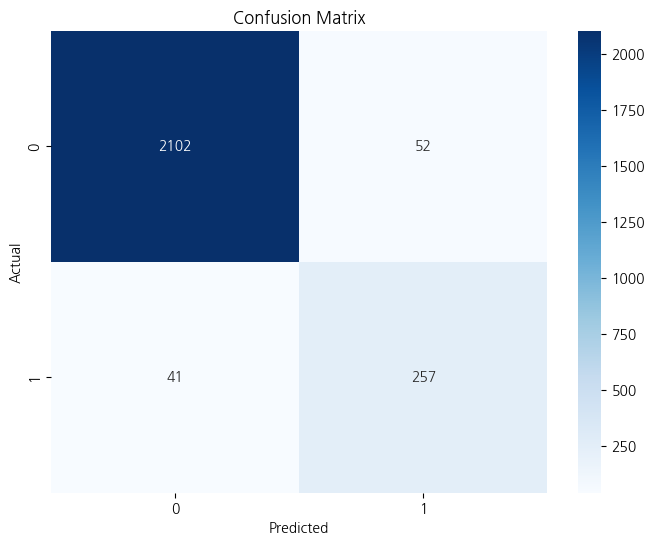

Submission file has been created successfully!


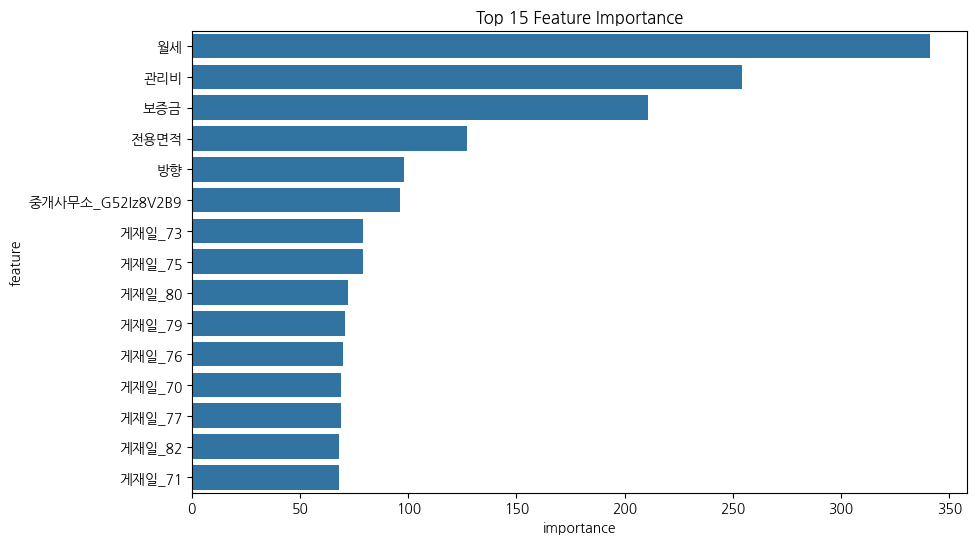

In [7]:

# 6. 모델 평가
oof_preds_binary = (oof_preds > 0.5).astype(int)
f1 = f1_score(y, oof_preds_binary, average='macro')
print(f"\nOOF F1 Score: {f1:.4f}")

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y, oof_preds_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 7. 제출 파일 생성
test_preds_binary = (test_preds > 0.5).astype(int)
submission = pd.DataFrame({
    'ID': id_mapping,
    '허위매물여부': test_preds_binary
})
submission.to_csv('submission.csv', index=False)
print("Submission file has been created successfully!")

# 8. 특성 중요도 시각화
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importance()
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importance')
plt.show()